# SWB Regression Pipeline - HFA Power 
Created: 07/30/24 \
Updated: 08/22/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08222024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [9]:
hfa_df = pd.read_csv(f'{save_dir}hfa_master_df.csv')
hfa_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [10]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [11]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [12]:
# #### filter df by rois with electrode counts >= 50 *** updated to >15
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
# ).values>=20].tolist()

keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
    roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
# keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']     
keep_rois


['dmpfc',
 'ofc',
 'acc',
 'sts',
 'hpc',
 'amy',
 'dlpfc',
 'stg',
 'vlpfc',
 'ains',
 'smg',
 'pins',
 'thalamus',
 'mtg']

In [13]:
# ####### NEW DATA FRAME 
hfa_reg_df = hfa_df.copy()
hfa_reg_df = hfa_reg_df[hfa_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [14]:
elec_col    = 'unique_reref_ch'
main_var    = 'decisionCPE'
reg_formula = 'band_pow~GambleChoice+TotalProfit+decisionCPE'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(hfa_reg_df,reg_formula,elec_col, main_var,n_permutations)

Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3414.25it/s]


In [15]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'decisionCPE']

In [16]:
results = single_elec_permutation_results(results_dict,hfa_df,save_vars)
results

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.009602,-0.019527,-0.024831,0.021213,-0.004172,0.000385,...,0.010428,0.010486,1.753374,-1.753374,-2.363372,1.993167,0.079538,0.079538,0.018109,0.046243
1,MS002_lacas2-lacas3,MS002,acc,14,0.013824,-0.026959,-0.020466,0.032208,-0.004889,0.000092,...,0.012713,0.012485,2.004012,-2.004012,-1.669439,2.527645,0.045069,0.045069,0.095030,0.011483
2,MS002_lacas3-lacas4,MS002,acc,14,0.018103,-0.030073,-0.034169,0.000575,-0.002591,-0.000160,...,0.013267,0.012851,2.161090,-2.161090,-2.582795,0.049131,0.030688,0.030688,0.009800,0.960815
3,MS002_lacas4-lacas5,MS002,acc,14,0.015891,-0.022747,-0.039756,0.001034,0.000294,-0.000201,...,0.014137,0.013846,1.457815,-1.457815,-2.804685,0.062269,0.144892,0.144892,0.005037,0.950348
4,MS002_lacas5-lacas6,MS002,acc,14,0.023452,-0.028664,-0.008658,-0.003695,0.004030,-0.000588,...,0.012256,0.012111,2.126374,-2.126374,-0.698427,-0.336926,0.033472,0.033472,0.484910,0.736172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,DA039_rpins6-rpins7,DA039,stg,22,0.004782,-0.042341,0.044020,-0.055510,-0.011009,-0.001147,...,0.039927,0.039905,0.965922,-0.965922,1.065001,-1.374954,0.334083,0.334083,0.286875,0.169146
1616,DA039_rpins7-rpins8,DA039,stg,22,0.004178,-0.027140,0.042991,-0.057898,-0.007075,0.002215,...,0.034211,0.035005,0.870918,-0.870918,1.248706,-1.670560,0.383799,0.383799,0.211773,0.094809
1617,DA039_rpins8-rpins9,DA039,stg,22,0.008739,-0.020844,0.022332,-0.054699,0.001312,-0.001470,...,0.039953,0.040650,0.461779,-0.461779,0.593708,-1.345814,0.644240,0.644240,0.552708,0.178362
1618,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.096861,0.042294,0.026198,0.028030,-0.080972,0.000843,...,0.022714,0.020846,-1.843491,1.843491,1.183666,1.352551,0.065257,0.065257,0.236545,0.176199


In [17]:
# # create a binary pickle file 
pickle.dump(results,
            open(f'{save_dir}single_elec_regression_hfa_{reg_formula}_{date}.pkl',"wb"))

In [18]:
sig_data = results[results.unique_elec_id.isin(main_var_sig)]
sig_data

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.009602,-0.019527,-0.024831,0.021213,-0.004172,0.000385,...,0.010428,0.010486,1.753374,-1.753374,-2.363372,1.993167,0.079538,0.079538,0.018109,0.046243
1,MS002_lacas2-lacas3,MS002,acc,14,0.013824,-0.026959,-0.020466,0.032208,-0.004889,0.000092,...,0.012713,0.012485,2.004012,-2.004012,-1.669439,2.527645,0.045069,0.045069,0.095030,0.011483
47,MS002_lpips3-lpips4,MS002,pins,14,0.015306,-0.032655,-0.033791,-0.044934,-0.007176,-0.000157,...,0.020452,0.020281,1.468057,-1.468057,-1.660713,-2.220732,0.142089,0.142089,0.096771,0.026369
58,MS002_racas6-racas7,MS002,dmpfc,14,0.021060,-0.002760,-0.027003,-0.028567,0.019091,0.000086,...,0.014037,0.013858,0.183862,-0.183862,-1.888842,-1.994696,0.854121,0.854121,0.058913,0.046076
59,MS002_racas7-racas8,MS002,dmpfc,14,0.023569,-0.002962,-0.018571,-0.031314,0.021474,0.000068,...,0.014689,0.014816,0.186350,-0.186350,-1.218818,-2.068341,0.852170,0.852170,0.222913,0.038608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,DA026_lpsmg6-lpsmg7,DA026,smg,19,-0.019041,0.044134,0.011911,0.026207,0.004513,0.000625,...,0.012839,0.012426,-3.403161,3.403161,0.921980,2.085225,0.000666,0.000666,0.356539,0.037049
1554,DA037_rsmg15-rsmg16,DA037,smg,4,-0.001303,0.012758,0.027633,-0.032089,0.001431,0.001137,...,0.015137,0.014936,-0.640817,0.640817,1.825686,-2.151133,0.521642,0.521642,0.067898,0.031466
1565,DA037_rof1-rof2,DA037,ofc,4,-0.012610,0.001246,0.034839,0.060822,-0.012220,-0.000412,...,0.023246,0.024042,-0.059360,0.059360,1.450635,2.523551,0.952665,0.952665,0.146882,0.011618
1572,DA037_rmc7-rmc8,DA037,dlpfc,4,-0.026976,0.074267,0.029557,-0.061234,-0.009434,-0.000288,...,0.020217,0.020226,-3.099507,3.099507,1.443875,-3.041726,0.001938,0.001938,0.148774,0.002352


In [19]:
sig_data.roi.value_counts()

acc         34
ofc         22
dmpfc       16
ains        14
smg         12
hpc          9
sts          8
amy          8
vlpfc        8
stg          6
dlpfc        6
pins         4
thalamus     4
mtg          3
Name: roi, dtype: int64

In [20]:
sig_data.roi.unique()

array(['acc', 'pins', 'dmpfc', 'mtg', 'ains', 'ofc', 'vlpfc', 'stg',
       'amy', 'dlpfc', 'sts', 'hpc', 'thalamus', 'smg'], dtype=object)

In [21]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']


In [22]:
results.groupby('roi').agg('mean')['Z_Score_decisionCPE'][bar_order]

roi
dlpfc   -0.091722
vlpfc    0.176266
dmpfc    0.091724
ofc      0.577836
ains     0.224353
pins     0.143079
acc      0.469127
hpc      0.175796
amy      0.399344
Name: Z_Score_decisionCPE, dtype: float64

In [23]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.009602,-0.019527,-0.024831,0.021213,-0.004172,0.000385,...,0.010428,0.010486,1.753374,-1.753374,-2.363372,1.993167,0.079538,0.079538,0.018109,0.046243
1,MS002_lacas2-lacas3,MS002,acc,14,0.013824,-0.026959,-0.020466,0.032208,-0.004889,0.000092,...,0.012713,0.012485,2.004012,-2.004012,-1.669439,2.527645,0.045069,0.045069,0.095030,0.011483
2,MS002_lacas3-lacas4,MS002,acc,14,0.018103,-0.030073,-0.034169,0.000575,-0.002591,-0.000160,...,0.013267,0.012851,2.161090,-2.161090,-2.582795,0.049131,0.030688,0.030688,0.009800,0.960815
3,MS002_lacas4-lacas5,MS002,acc,14,0.015891,-0.022747,-0.039756,0.001034,0.000294,-0.000201,...,0.014137,0.013846,1.457815,-1.457815,-2.804685,0.062269,0.144892,0.144892,0.005037,0.950348
4,MS002_lacas5-lacas6,MS002,acc,14,0.023452,-0.028664,-0.008658,-0.003695,0.004030,-0.000588,...,0.012256,0.012111,2.126374,-2.126374,-0.698427,-0.336926,0.033472,0.033472,0.484910,0.736172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,DA039_rpins1-rpins2,DA039,pins,22,-0.000885,-0.018211,0.018350,0.001634,-0.007721,-0.000380,...,0.018140,0.017652,0.966894,-0.966894,1.081925,0.117325,0.333597,0.333597,0.279286,0.906603
1611,DA039_rpins2-rpins3,DA039,pins,22,-0.000429,-0.038045,0.028140,-0.020577,-0.015524,0.001334,...,0.026096,0.027036,1.476912,-1.476912,1.090891,-0.818857,0.139699,0.139699,0.275321,0.412868
1612,DA039_rpins3-rpins4,DA039,pins,22,0.001596,-0.051768,0.039688,-0.042583,-0.018120,-0.000335,...,0.038485,0.037499,1.354825,-1.354825,1.041984,-1.192441,0.175473,0.175473,0.297419,0.233088
1618,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.096861,0.042294,0.026198,0.028030,-0.080972,0.000843,...,0.022714,0.020846,-1.843491,1.843491,1.183666,1.352551,0.065257,0.065257,0.236545,0.176199


In [24]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)

In [25]:
agg_single_results = single_elec_res.groupby('roi').agg('mean')[['Z_Score_decisionCPE']].copy()

agg_single_results


,Z_Score_decisionCPE
roi,
acc,0.469127
ains,0.224353
amy,0.399344
dlpfc,-0.091722
dmpfc,0.091724
hpc,0.175796
ofc,0.577836
pins,0.143079
vlpfc,0.176266


In [26]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_decisionCPE'] = agg_single_results.Z_Score_decisionCPE
single_rho_data[['Z_Score_decisionCPE','rho','rho_p']]

,Z_Score_decisionCPE,rho,rho_p
roi,,,
acc,0.469127,-0.163836,0.0228
dmpfc,0.091724,-0.137354,0.0437
amy,0.399344,-0.291450,0.0017
ains,0.224353,-0.207564,0.0824
vlpfc,0.176266,-0.028526,0.7992
hpc,0.175796,-0.156421,0.0700
ofc,0.577836,0.044827,0.5264
pins,0.143079,-0.073324,0.5777
dlpfc,-0.091722,-0.039460,0.6866


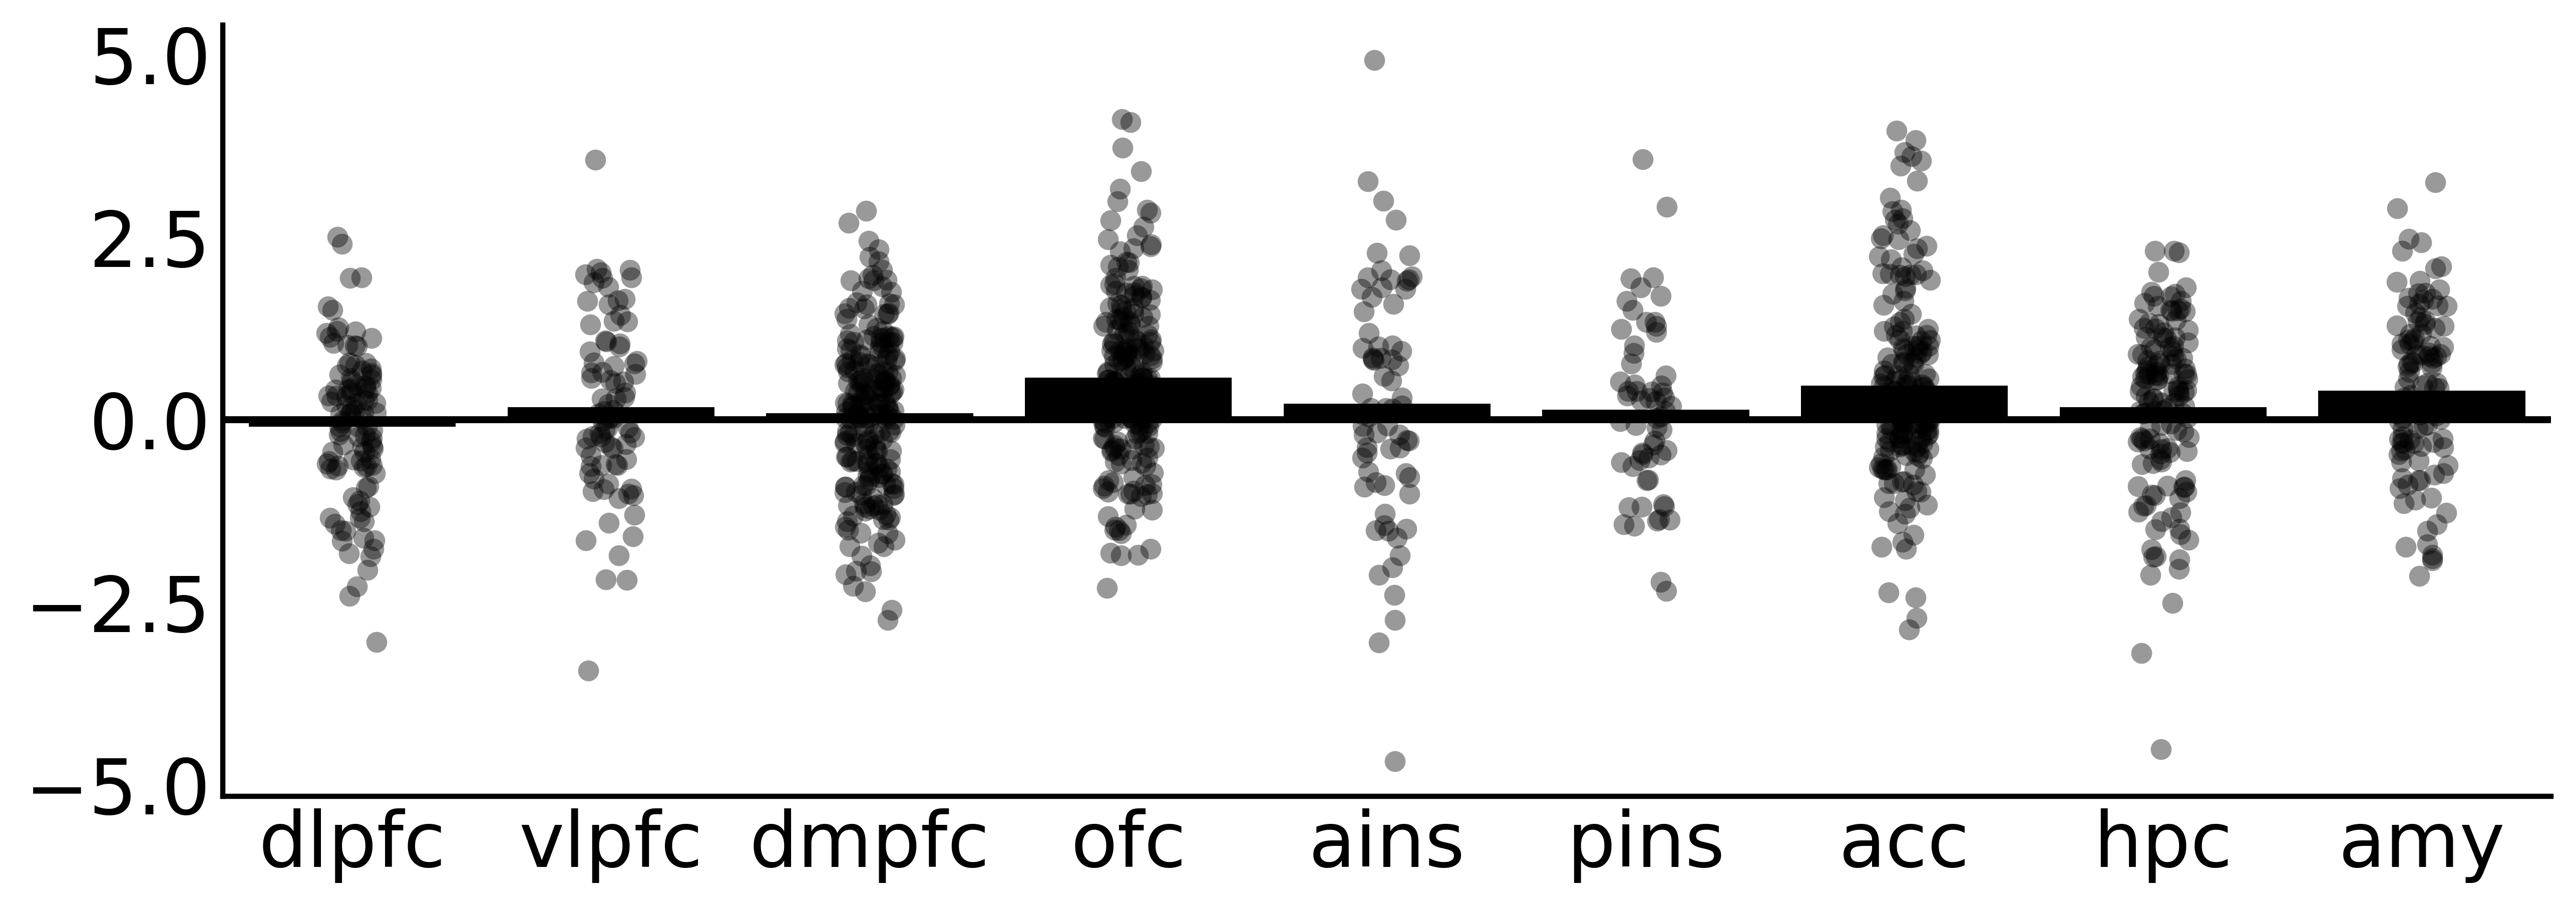

In [30]:
plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(12,4),color='k')
# green '#135546'


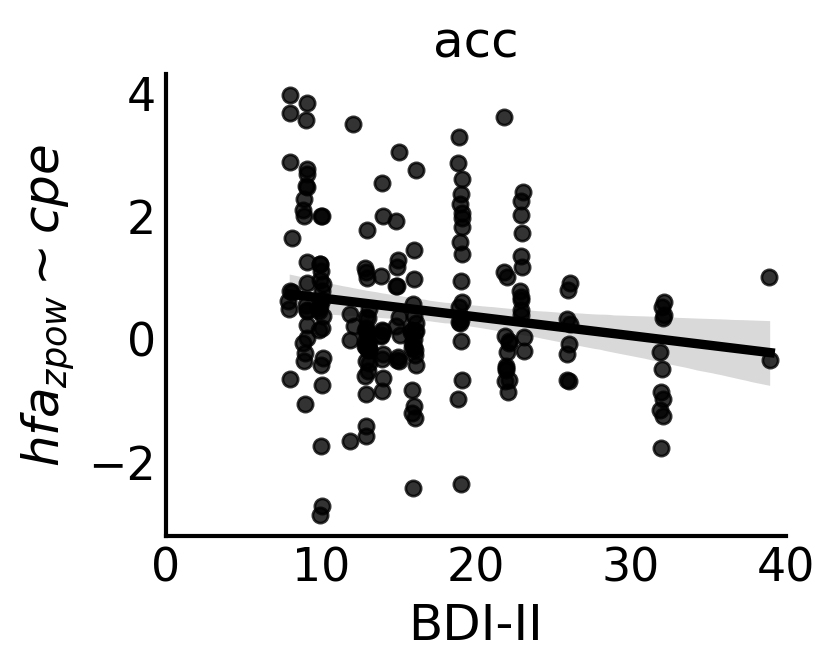

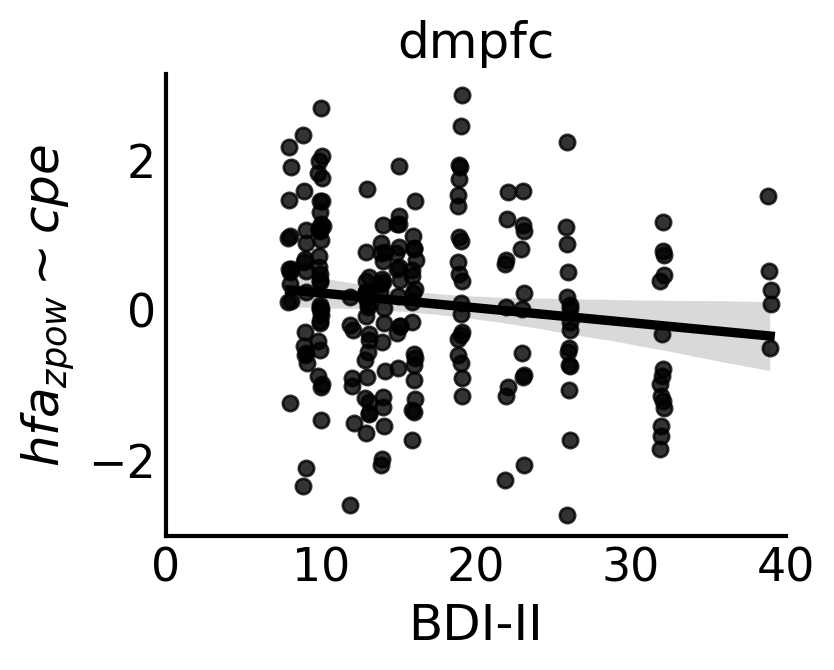

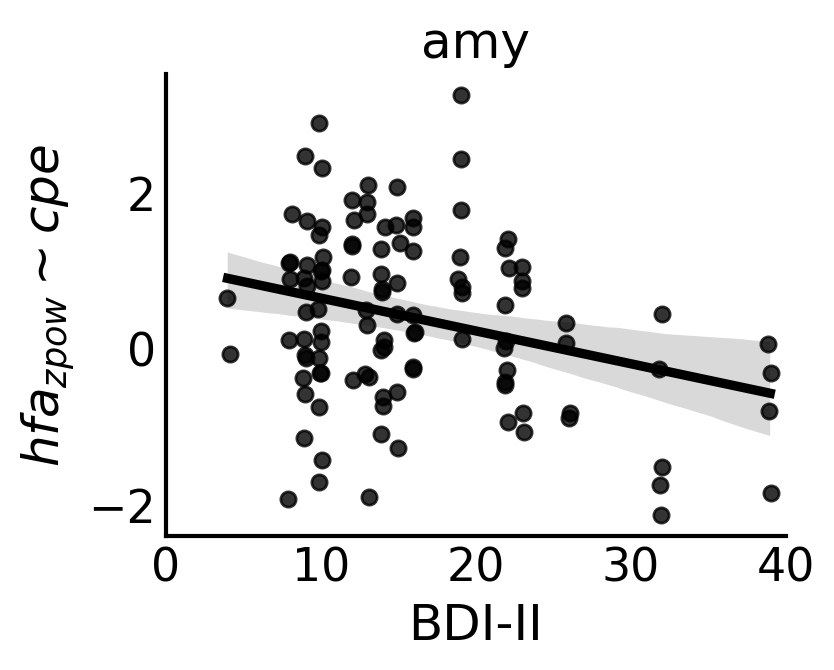

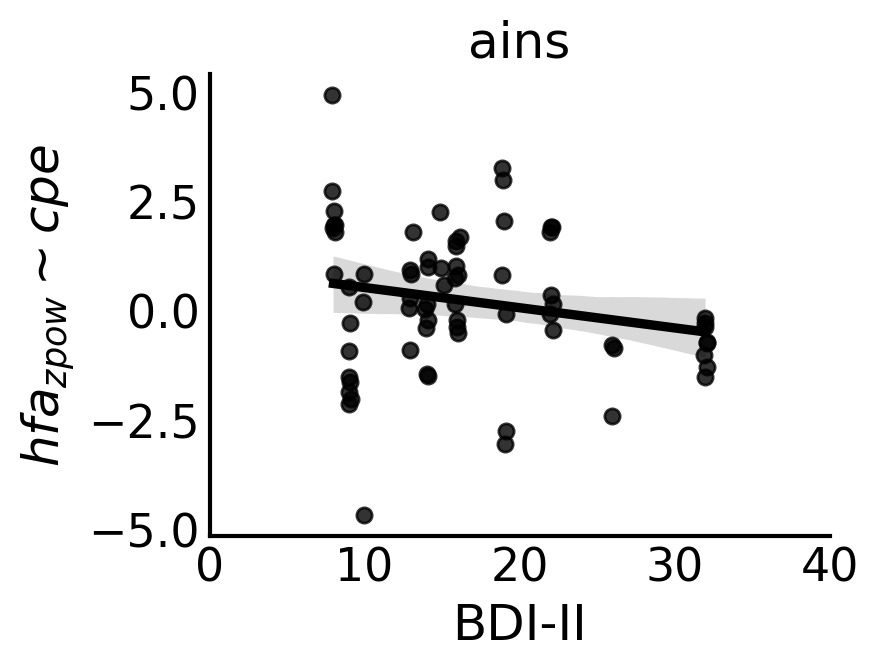

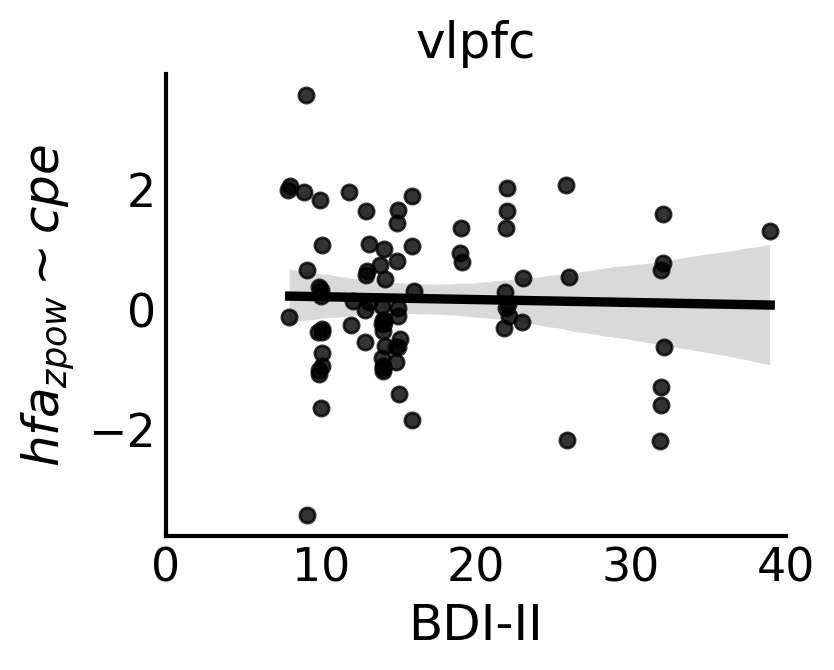

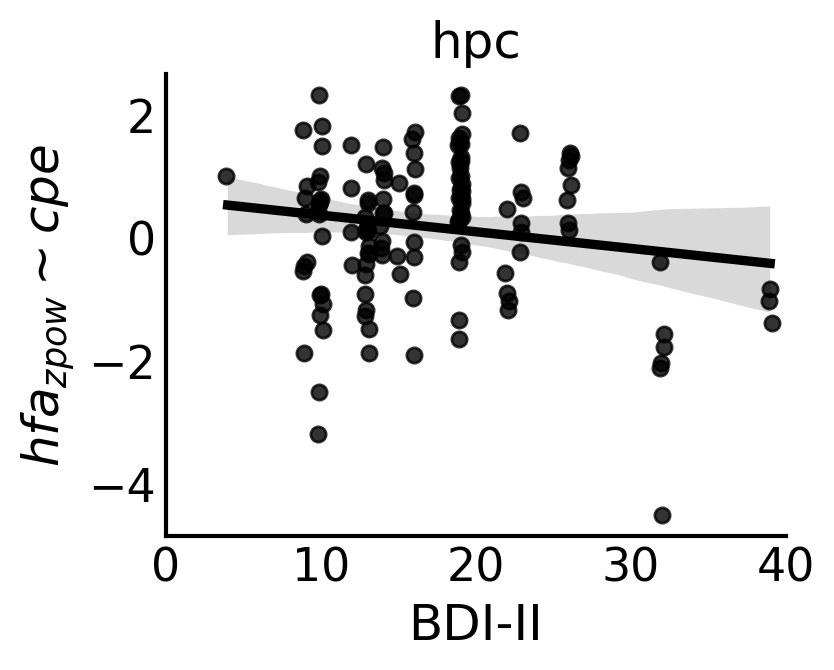

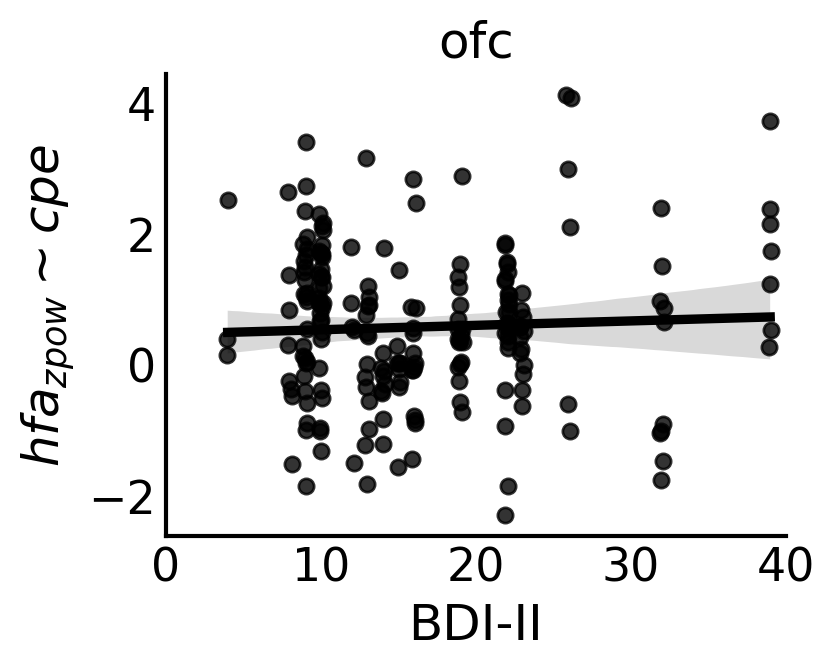

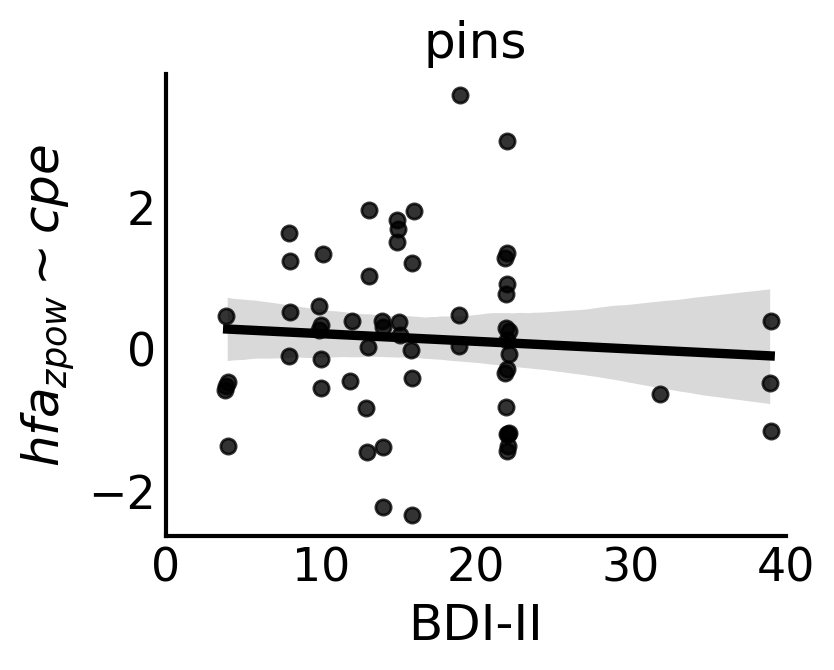

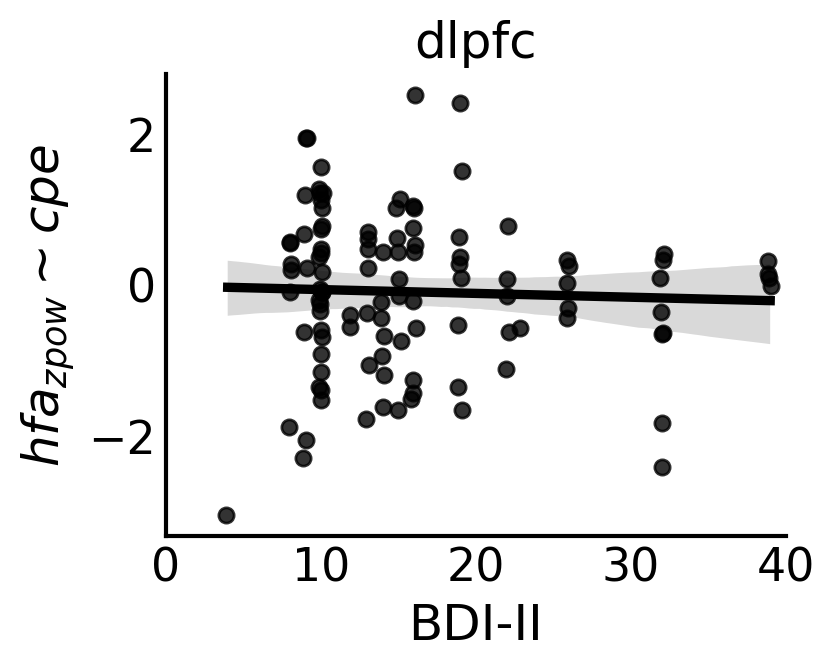

In [28]:
band = 'hfa'

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()


### Test BDI Correlations via robust regression

In [29]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_decisionCPE.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 22 Aug 2024                                         
Time:                        11:33:26                                         
No. Iterations:                    12                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1334      0.472     34.206     

# Mixed effects models

In [35]:
reg_df = hfa_df.copy()
reg_df = reg_df[reg_df.roi.isin(bar_order)]
reg_df


,Unnamed: 0,subj_id,bdi,reref_ch_names,unique_reref_ch,epoch,freq,band,band_pow,roi,...,SafeBet,GambleChoice,GambleChoice_t1,TrialEV,Profit,TotalProfit,RPE,decisionCPE,decisionRegret,decisionRelief
0,0,MS002,14,lacas1-lacas2,MS002_lacas1-lacas2,0,118.986976,hfa,-0.015832,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
1,1,MS002,14,lacas2-lacas3,MS002_lacas2-lacas3,0,118.986976,hfa,-0.053265,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
2,2,MS002,14,lacas3-lacas4,MS002_lacas3-lacas4,0,118.986976,hfa,-0.019960,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
3,3,MS002,14,lacas4-lacas5,MS002_lacas4-lacas5,0,118.986976,hfa,-0.061600,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
4,4,MS002,14,lacas5-lacas6,MS002_lacas5-lacas6,0,118.986976,hfa,-0.195597,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258455,258455,DA039,22,rpins1-rpins2,DA039_rpins1-rpins2,148,118.986976,hfa,-0.164942,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258456,258456,DA039,22,rpins2-rpins3,DA039_rpins2-rpins3,148,118.986976,hfa,-0.115631,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258457,258457,DA039,22,rpins3-rpins4,DA039_rpins3-rpins4,148,118.986976,hfa,-0.193613,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258470,258470,DA039,22,rsgcc6-rsgcc7,DA039_rsgcc6-rsgcc7,148,118.986976,hfa,-0.162934,vlpfc,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244


In [36]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'decisionCPE','roi','hemi','bdi','bdi:decisionCPE']
rand_vars    = ['GambleChoice','TotalProfit', 'decisionCPE']


In [37]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [38]:
roi_fit_results['band'] = 'hfa'
# roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

# raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
#                  popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
# raw_roi_stats

In [40]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha

0.005555555555555556

In [41]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois

['acc', 'amy']

In [42]:
sig_cpe_bdi_rois = fe_results.roi[fe_results.cpe_bdi_pval <= bonferr_alpha].tolist()
sig_cpe_bdi_rois

['amy']

In [39]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]
fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


,Intercept,GambleChoice[T.safe],hemi[T.r],TotalProfit,decisionCPE,bdi,bdi:decisionCPE,roi,cpe_pval,bdi_pval,cpe_bdi_pval
0,-0.001170,-0.006725,0.003880,-0.016278,0.011847,-0.000211,-0.000353,acc,0.0004,0.1798,0.0604
1,-0.012823,0.003165,0.009863,-0.016015,0.005782,0.000083,-0.000282,dmpfc,0.0804,0.7410,0.1177
2,-0.011194,0.004100,-0.003365,0.004985,0.018018,-0.000703,-0.000786,amy,0.0001,0.1369,0.0024
3,0.010936,0.000427,0.011294,0.001492,0.013960,-0.000753,-0.000628,ains,0.0535,0.1488,0.1184
4,-0.015014,0.008152,-0.001037,-0.012118,0.006527,0.000544,-0.000196,vlpfc,0.3438,0.3994,0.6144
5,-0.118569,0.006704,-0.017159,0.000568,0.013542,0.003443,-0.000727,hpc,0.0083,0.0135,0.0092
6,0.004837,0.013501,-0.014745,-0.011378,0.009104,-0.001022,0.000083,ofc,0.0217,0.0655,0.7014
7,-0.072810,-0.001643,0.047446,0.008999,0.005200,-0.000439,-0.000261,pins,0.4858,0.8350,0.5236
8,-0.003768,0.016253,-0.006951,-0.011643,-0.000470,-0.000479,0.000116,dlpfc,0.9364,0.2963,0.7108


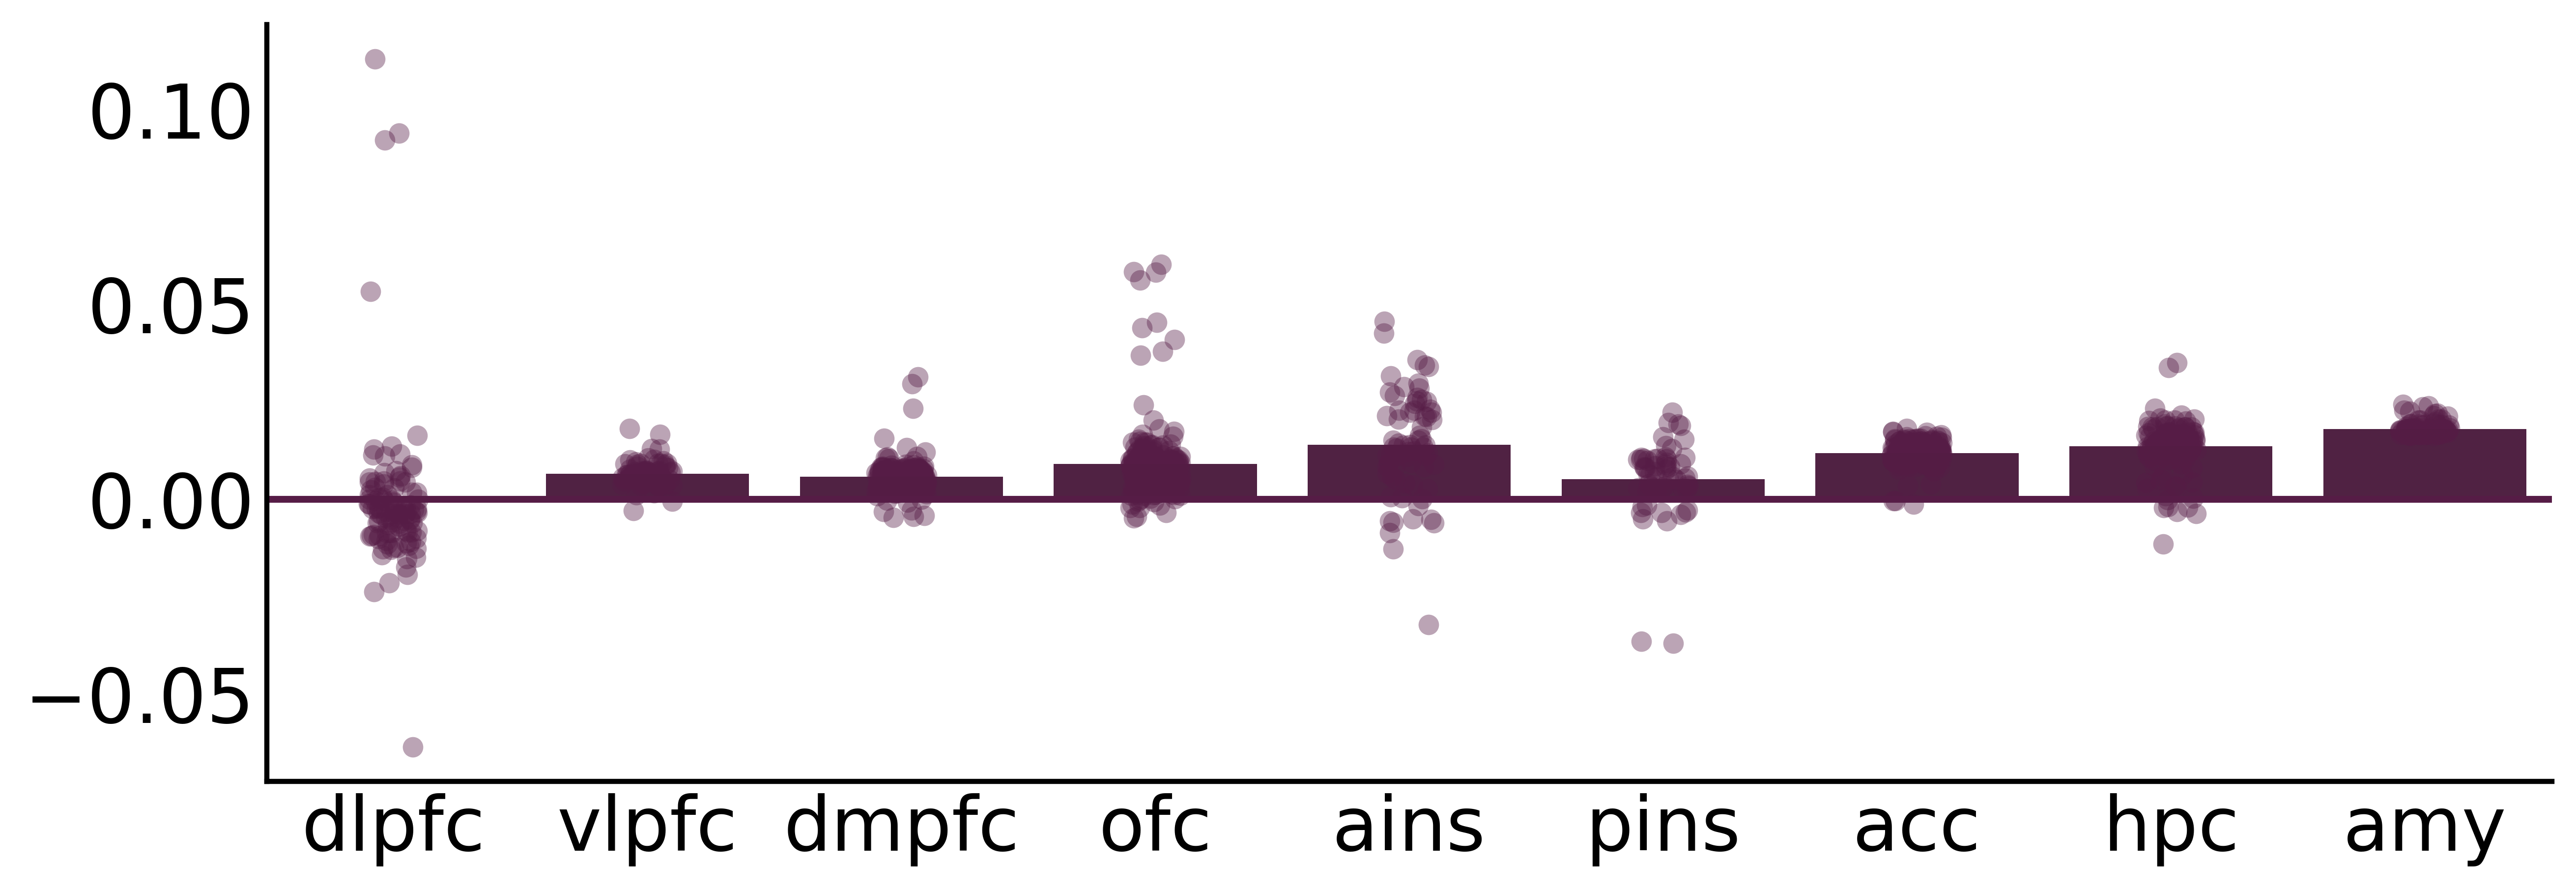

In [43]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=bar_order,figsize=(12,4),color='#561C46')


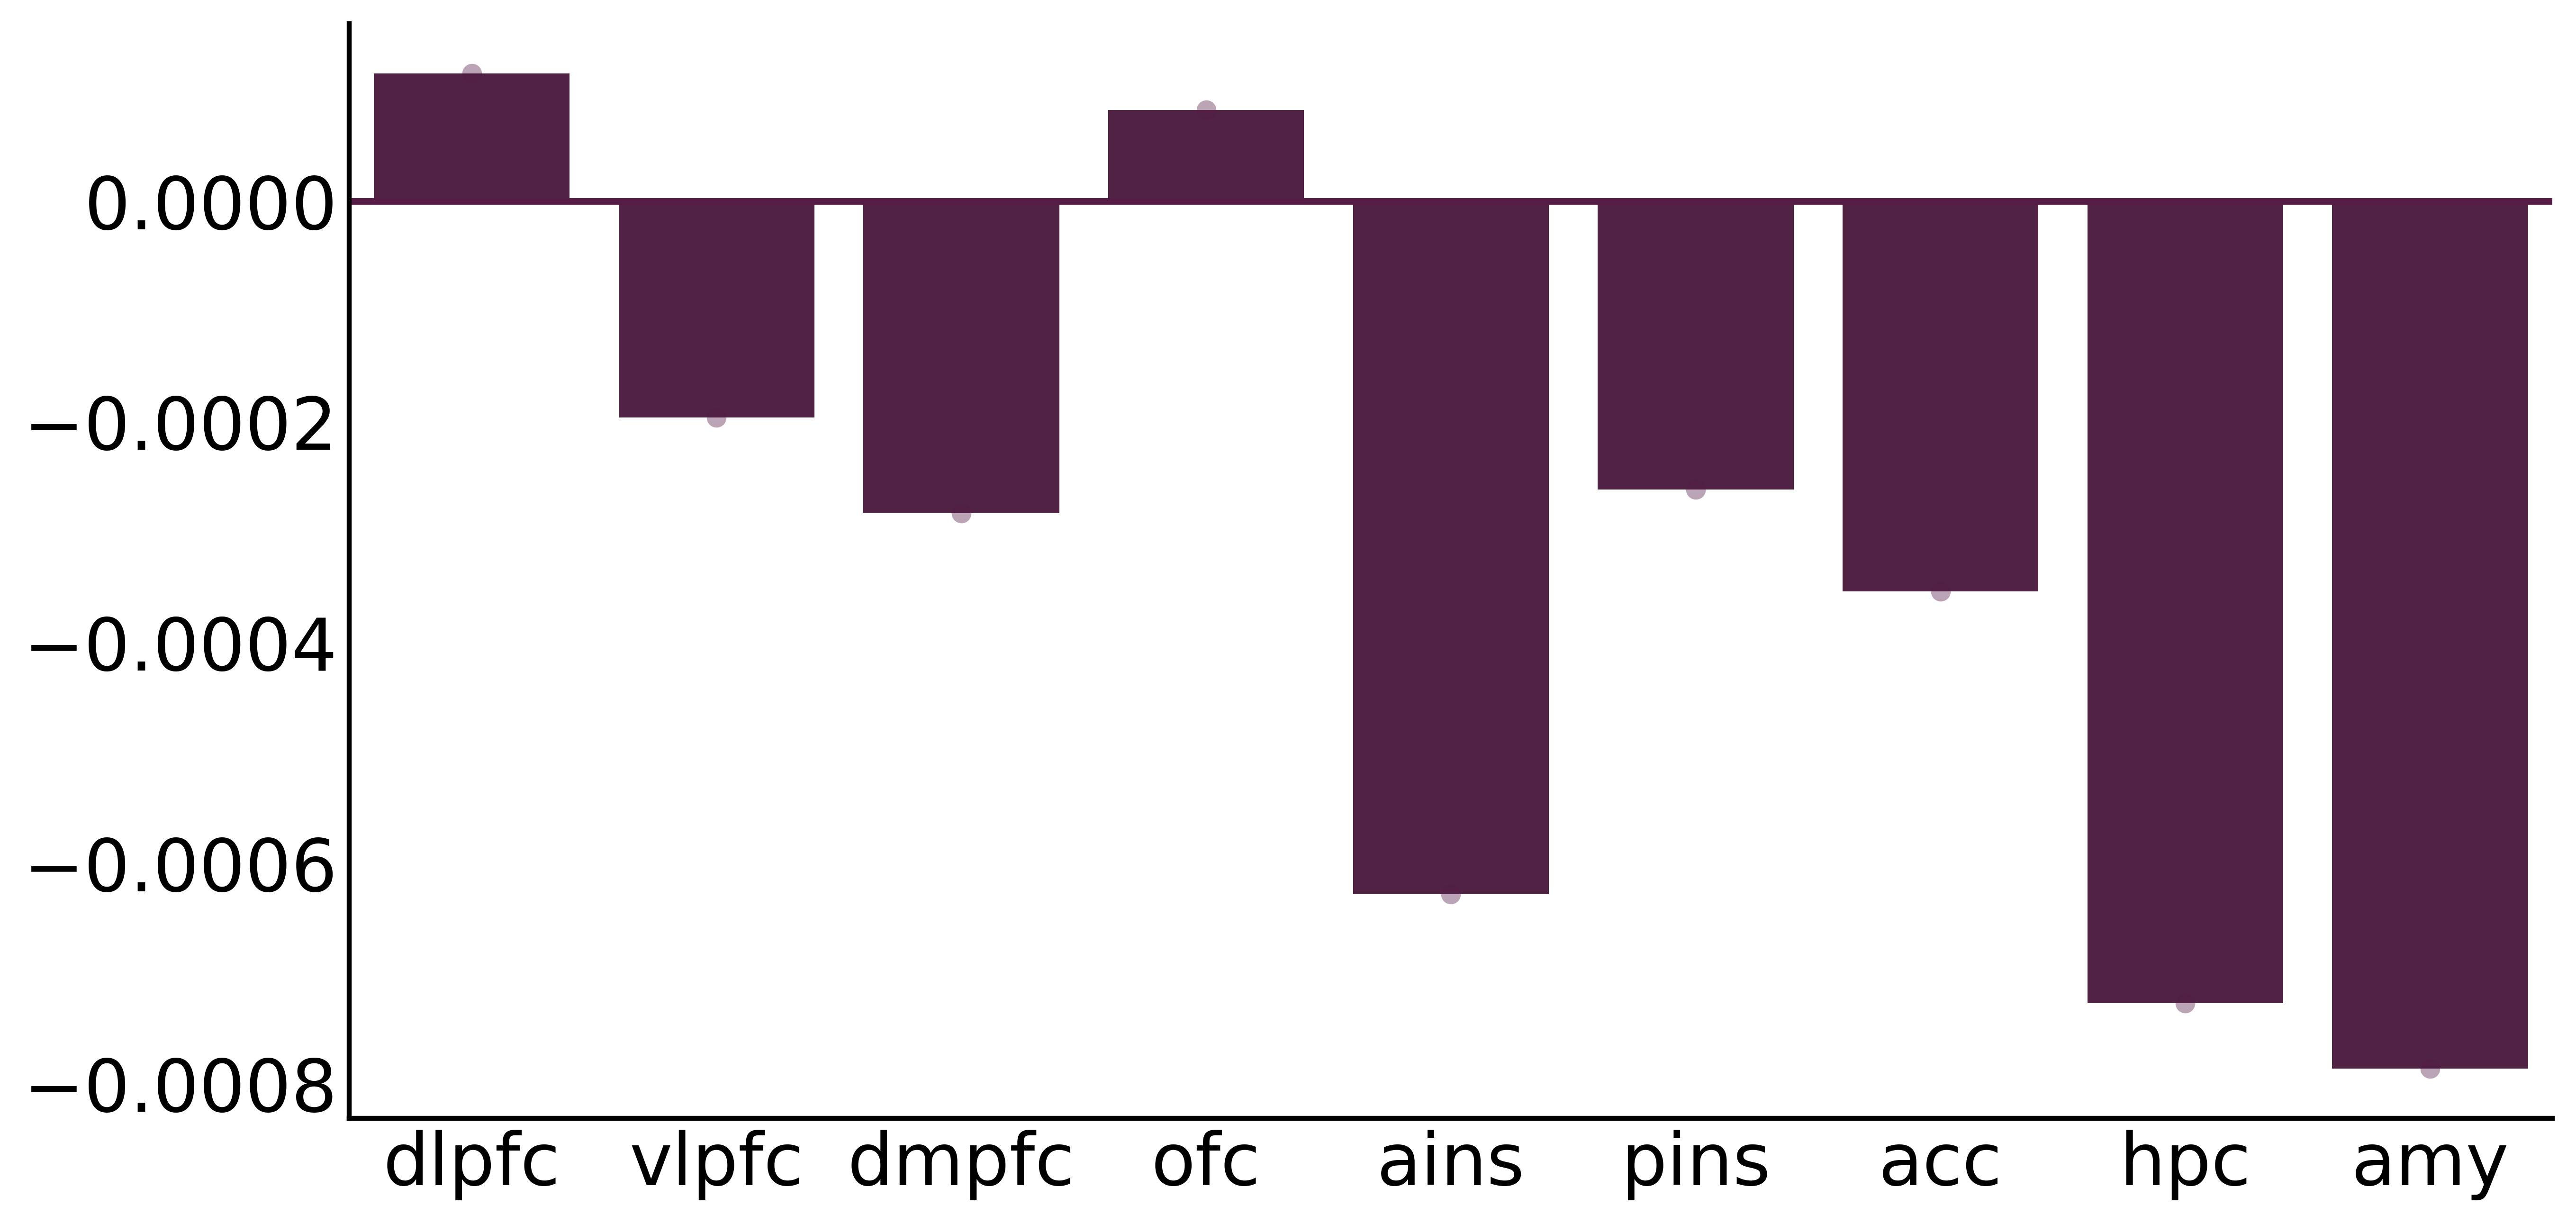

In [44]:
plot_roi_model_results(fe_results,'roi',"bdi:decisionCPE",bar_order=bar_order,figsize=(12,6),color='#561C46')
# add to slides 
